# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

import datetime
from time import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score

from sklearn.svm import SVC

% matplotlib inline

# read the json data files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#Access the portfolio data
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
print("portfolio: Rows = {0}, Columns = {1}".format(str(portfolio.shape[0]), str(portfolio.shape[1])))

portfolio: Rows = 10, Columns = 6


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
def horizontal_bar_plot(df, colName, pltTitle, figsize=[5,5], InvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot
    
    Input
    ----------
    df: The dataframe with categories.
    colName: The name of the column containing the categories.
    pltTitle: The plot title.
    figsize: The figure size of the plot (default is [5,5]).
    InvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    fntSize: The font size of text (default to 12 point font size)
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=figsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if InvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

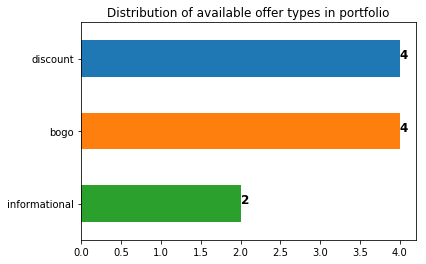

In [7]:
horizontal_bar_plot(portfolio, 'offer_type', "Distribution of available offer types in portfolio")

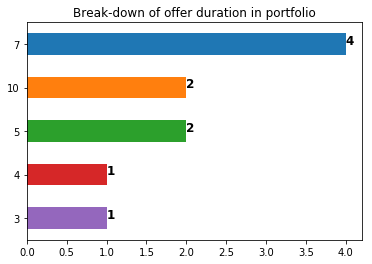

In [8]:
horizontal_bar_plot(portfolio, 'duration', "Break-down of offer duration in portfolio")

In [9]:
#Exploring the profile
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
print("profile: Rows = {0}, Columns = {1}".format(str(profile.shape[0]), str(profile.shape[1])))

profile: Rows = 17000, Columns = 5


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
#checking is null values in profile data
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [14]:
#To confirm profile having age as 118 has null values in gender and income
profile[profile['age']== 118].drop(['became_member_on' ,'id'], axis=1)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


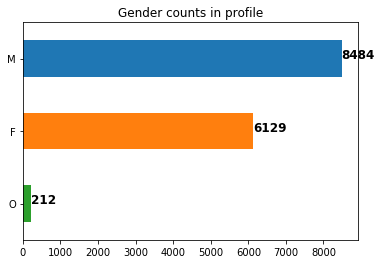

In [15]:
horizontal_bar_plot(profile, 'gender', "Gender counts in profile")

In [16]:
#Explore transcript data
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [17]:
print("transcript: Rows = {0}, Columns = {1}".format(str(transcript.shape[0]), str(transcript.shape[1])))

transcript: Rows = 306534, Columns = 4


In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [19]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


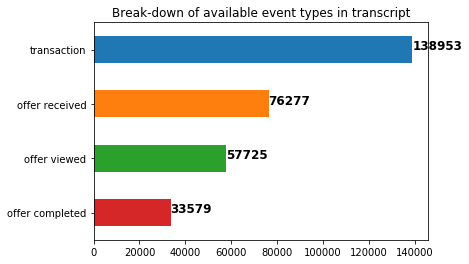

In [20]:
horizontal_bar_plot(transcript, 'event', "Break-down of available event types in transcript")

In [21]:
#Cleaning the porfolio data 
def clean_portfolio(portfolio):
    
    # change the duration from day to hour
    portfolio['duration'] = portfolio['duration'] * 24
    portfolio.rename(columns = {'id': 'offer_id'}, inplace = True)
    
    # apply binary encoding to channels column
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'], prefix = 'offer')
    
    # drop the channels and offer_type column
    portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)
    
    return portfolio

In [22]:
cleaned_portfolio = clean_portfolio(portfolio)

In [23]:
cleaned_portfolio

,difficulty,duration,offer_id,reward,web,email,mobile,social,offer_bogo,offer_discount,offer_informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [24]:
#Cleaning the profile data 
import datetime
def clean_profile(profile):
    
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    #Changing 'id' column name to 'customer_id'
    profile.rename(columns = {'id': 'customer_id'}, inplace = True)
    profile.rename(columns = {'income': 'customer_income'}, inplace = True)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    #add Age_group column
    profile.loc[(profile.age < 20) , 'Age_group'] = 'Under 20'
    profile.loc[(profile.age >= 20) & (profile.age <= 45) , 'Age_group'] = '20-45'
    profile.loc[(profile.age >= 46) & (profile.age <= 60) , 'Age_group'] = '46-60'
    profile.loc[(profile.age >= 61) , 'Age_group'] = '61-80'
    profile.drop('age',axis=1,inplace=True)
    
    return profile

In [25]:
cleaned_profile = clean_profile(profile)

In [26]:
cleaned_profile

,became_member_on,gender,customer_id,customer_income,memberdays,Age_group
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1450,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1517,61-80
5,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,1165,61-80
8,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,1241,61-80
12,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1331,46-60
13,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1392,61-80
14,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2698,20-45
15,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,1970,61-80
16,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,2425,46-60
18,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,1281,46-60


In [27]:
cleaned_profile.describe()

,became_member_on,customer_income,memberdays
count,1.482500e+04,14825.000000,14825.000000
mean,2.016689e+07,65404.991568,1596.478988
std,1.188565e+04,21598.299410,419.205158
min,2.013073e+07,30000.000000,1074.000000
25%,2.016052e+07,49000.000000,1282.000000
50%,2.017080e+07,64000.000000,1432.000000
75%,2.017123e+07,80000.000000,1871.000000
max,2.018073e+07,120000.000000,2897.000000


In [28]:
def display_customer_profile():
    '''Display customer profile with histograms'''
    
    # Display Histogram of Customer Age
    #user_age = cleaned_profile['Age_group'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
    #user_age.set_xlabel("Customer Age")
       
    # Display Histogram of the days being member
    plt.figure()
    memberdays = cleaned_profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become our members?')
    memberdays.set_xlabel("Days")
    
    # Display Histogram of User Income
    plt.figure()
    user_income = cleaned_profile['customer_income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
    user_income.set_xlabel("Income")

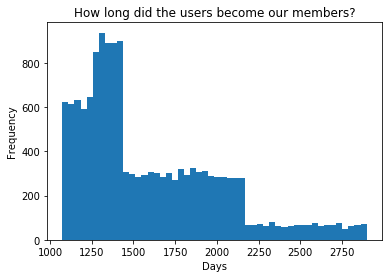

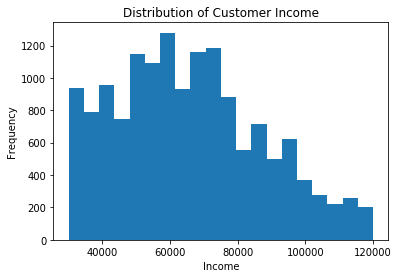

In [29]:
display_customer_profile()

In [30]:
#Cleaning Transcript data
def clean_transcript(transcript):
    """
    Cleaning the transcript data frame.
    
    Input
    ----------   
    transcript: transcript data frame
    
    Returns
    -------
    df: output data frame as per task
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    #rename column 'person' to 'customer_id'
    transcript.rename(columns = {'person': 'customer_id'}, inplace = True)
    
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
   
    #expand the dictionary to coulmns 
    transcript['money_gained'] = transcript['value'].apply(lambda x: x.get('reward'))
    transcript['money_spent'] = transcript['value'].apply(lambda x: x.get('amount'))
    
    
    #replace nan
    transcript.fillna(0 , inplace=True)
    
    return transcript

In [31]:
cleaned_transcript = clean_transcript(transcript)

In [32]:
cleaned_transcript

,event,customer_id,time,value,offer_id,money_gained,money_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,0.0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d,0.0,0
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,0.0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0


In [33]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 7 columns):
event           167581 non-null object
customer_id     167581 non-null object
time            167581 non-null int64
value           167581 non-null object
offer_id        167581 non-null object
money_gained    167581 non-null float64
money_spent     167581 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 10.2+ MB


In [34]:
#Merging the data into final dataframe
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames for  Exploratory Data Analysis (EDA)
       
    Input
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [35]:
merged_df = merge_data(cleaned_portfolio, cleaned_profile, cleaned_transcript)

In [36]:
merged_df.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,offer_bogo,offer_discount,...,customer_id,time,value,money_gained,money_spent,became_member_on,gender,customer_income,memberdays,Age_group
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
1,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,102,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
2,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,504,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
3,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,510,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
4,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,10.0,0,20170909,M,100000.0,1394,61-80


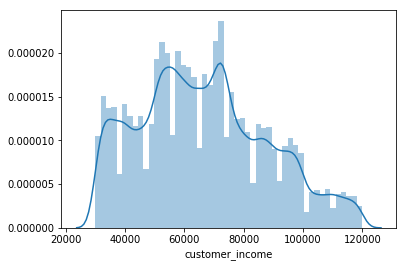

In [37]:
sns.distplot(merged_df['customer_income'], bins=50, hist_kws={'alpha': 0.4});

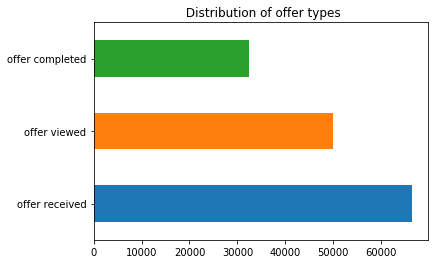

In [38]:
merged_df['event'].value_counts().plot.barh(title=' Distribution of offer types')

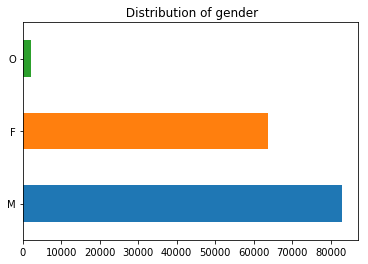

In [39]:
merged_df['gender'].value_counts().plot.barh(title=' Distribution of gender')

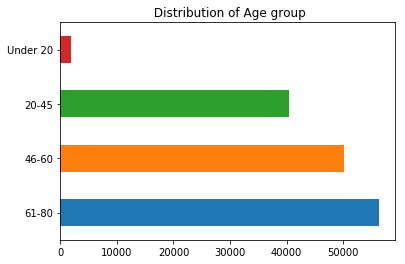

In [40]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of Age group')

In [41]:
plot_gender = merged_df[merged_df['gender'] != 'O']

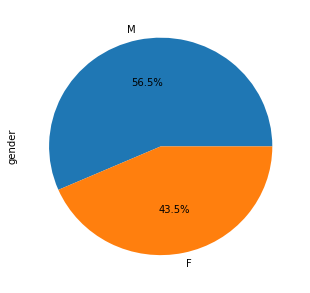

In [42]:
plot_gender.gender.value_counts().plot(kind='pie' , figsize=(5, 5), autopct='%1.1f%%')

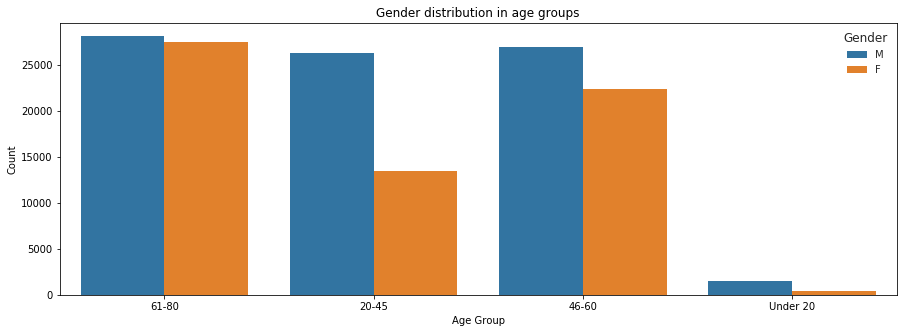

In [43]:
#plotting Gender distribution
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

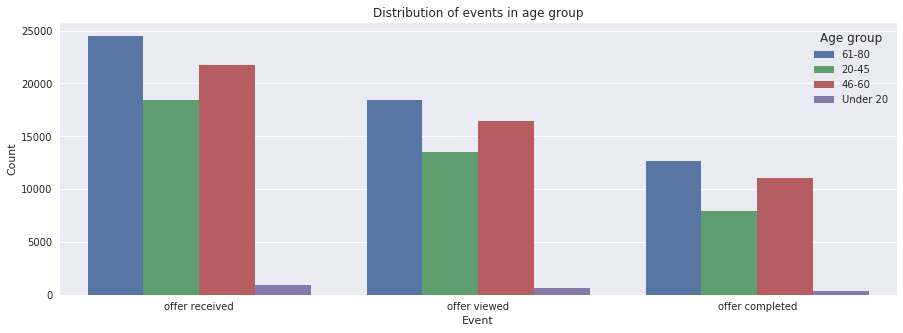

In [44]:
#Plotting evnts distribution in age group
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "Age_group", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Distribution of events in age group')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Age group')

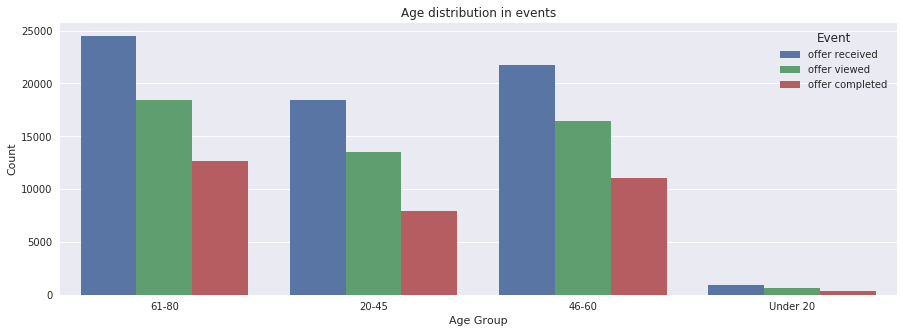

In [45]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

In [63]:
merged_df.head()

,difficulty,duration,offer_id,reward,web,email,mobile,social,offer_bogo,offer_discount,...,customer_id,time,value,money_gained,money_spent,became_member_on,gender,customer_income,memberdays,Age_group
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
1,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,102,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
2,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,504,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
3,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,510,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0.0,0,20170909,M,100000.0,1394,61-80
4,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,4b0da7e80e5945209a1fdddfe813dbe0,510,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,10.0,0,20170909,M,100000.0,1394,61-80


In [66]:
def clean_final_data(df):
    """
    Clean merged data frame for the final data.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    #df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #drop value column
    df.drop('value', axis=1, inplace=True)
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'difficulty', 'duration', 'reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [67]:
cleaned_final_data = clean_final_data(merged_df)

In [69]:
cleaned_final_data.head(10)

,difficulty,duration,offer_id,reward,web,email,mobile,social,offer_bogo,offer_discount,...,memberdays,gender_F,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,month_member,year_member
0,0.5,0.571429,0,1.0,0,1,1,1,1,0,...,1394,0,1,0,0,0,1,0,9,2017
1,0.5,0.571429,0,1.0,0,1,1,1,1,0,...,1394,0,1,0,0,0,1,0,9,2017
2,0.5,0.571429,0,1.0,0,1,1,1,1,0,...,1394,0,1,0,0,0,1,0,9,2017
3,0.5,0.571429,0,1.0,0,1,1,1,1,0,...,1394,0,1,0,0,0,1,0,9,2017
4,0.5,0.571429,0,1.0,0,1,1,1,1,0,...,1394,0,1,0,0,0,1,0,9,2017
5,0.0,0.142857,1,0.0,1,1,1,0,0,0,...,1394,0,1,0,0,0,1,0,9,2017
6,0.0,0.142857,1,0.0,1,1,1,0,0,0,...,1394,0,1,0,0,0,1,0,9,2017
7,1.0,1.000000,2,0.5,1,1,0,0,0,1,...,1394,0,1,0,0,0,1,0,9,2017
8,1.0,1.000000,2,0.5,1,1,0,0,0,1,...,1394,0,1,0,0,0,1,0,9,2017
9,1.0,1.000000,2,0.5,1,1,0,0,0,1,...,1394,0,1,0,0,0,1,0,9,2017


In [70]:
cleaned_final_data.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'web', 'email',
       'mobile', 'social', 'offer_bogo', 'offer_discount',
       'offer_informational', 'event', 'customer_id', 'time', 'money_gained',
       'money_spent', 'customer_income', 'memberdays', 'gender_F', 'gender_M',
       'gender_O', 'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'month_member', 'year_member'],
      dtype='object')

In [71]:
cleaned_final_data.event.value_counts()

1    66501
2    49860
3    32444
Name: event, dtype: int64

In [72]:
cleaned_final_data.shape

(148805, 27)

In [74]:
data = cleaned_final_data.drop('event', axis=1)
label = cleaned_final_data['event']

In [75]:
cleaned_final_data.columns

Index(['difficulty', 'duration', 'offer_id', 'reward', 'web', 'email',
       'mobile', 'social', 'offer_bogo', 'offer_discount',
       'offer_informational', 'event', 'customer_id', 'time', 'money_gained',
       'money_spent', 'customer_income', 'memberdays', 'gender_F', 'gender_M',
       'gender_O', 'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'month_member', 'year_member'],
      dtype='object')

In [76]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.4, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 89283 rows
Testing set: 59522 rows


In [77]:
X_train.head(10)

,difficulty,duration,offer_id,reward,web,email,mobile,social,offer_bogo,offer_discount,...,memberdays,gender_F,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,month_member,year_member
125889,0.50,1.000000,6,0.2,1,1,1,1,0,1,...,1302,0,1,0,0,1,0,0,10,2017
13344,0.25,0.285714,7,0.5,1,1,1,1,1,0,...,1214,0,1,0,1,0,0,0,8,2018
47994,0.35,0.571429,4,0.3,1,1,1,1,0,1,...,1404,0,1,0,1,0,0,0,30,2017
3547,0.35,0.571429,4,0.3,1,1,1,1,0,1,...,2370,0,1,0,1,0,0,0,7,2015
145936,0.50,1.000000,6,0.2,1,1,1,1,0,1,...,2148,0,1,0,0,1,0,0,17,2015
65693,0.50,0.571429,9,0.2,1,1,1,0,0,1,...,1415,0,1,0,1,0,0,0,19,2017
136184,0.50,1.000000,6,0.2,1,1,1,1,0,1,...,1169,0,1,0,1,0,0,0,22,2018
5168,0.00,0.142857,1,0.0,1,1,1,0,0,0,...,1372,1,0,0,1,0,0,0,1,2017
103452,0.25,0.285714,7,0.5,1,1,1,1,1,0,...,1395,0,1,0,0,1,0,0,8,2017
22307,0.50,0.285714,3,1.0,1,1,1,1,1,0,...,1842,1,0,0,0,1,0,0,18,2016


In [78]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89283 entries, 125889 to 43567
Data columns (total 26 columns):
difficulty             89283 non-null float64
duration               89283 non-null float64
offer_id               89283 non-null int64
reward                 89283 non-null float64
web                    89283 non-null int64
email                  89283 non-null int64
mobile                 89283 non-null int64
social                 89283 non-null int64
offer_bogo             89283 non-null uint8
offer_discount         89283 non-null uint8
offer_informational    89283 non-null uint8
customer_id            89283 non-null int64
time                   89283 non-null float64
money_gained           89283 non-null float64
money_spent            89283 non-null float64
customer_income        89283 non-null float64
memberdays             89283 non-null int64
gender_F               89283 non-null uint8
gender_M               89283 non-null uint8
gender_O               89283 non-nul

In [81]:
from sklearn.metrics import fbeta_score
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

In [82]:
#KNeighborsClassifier (Benchmark)
#Using KNN to build benchmark and evaluate F1 score
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [83]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [84]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,53.101934,32.209939


In [85]:
#RandomForestClassifier
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [86]:
rfc = {'Model': [ b_model], 'train F1 score':[b_train_f1], 'test F1 score': [b_test_f1]}
model_1 = pd.DataFrame(rfc)

In [87]:
model_1

,Model,train F1 score,test F1 score
0,RandomForestClassifier,94.496153,68.483922


In [88]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

In [89]:
dtc = {'Model': [ c_model], 'train F1 score':[c_train_f1], 'test F1 score': [c_test_f1]}
model_2 = pd.DataFrame(dtc)

In [90]:
model_2

,Model,train F1 score,test F1 score
0,DecisionTreeClassifier,95.704669,85.561641


In [94]:
clf_D = AdaBoostClassifier()
d_train_f1, d_test_f1, d_model = train_test(clf_D)

In [95]:
abc = {'Model': [ d_model], 'train F1 score':[d_train_f1], 'test F1 score': [d_test_f1]}
model_3 = pd.DataFrame(abc)

In [96]:
model_3

,Model,train F1 score,test F1 score
0,AdaBoostClassifier,92.670497,92.725379


In [97]:
clf_E = GaussianNB()
e_train_f1, e_test_f1, e_model = train_test(clf_E)

In [98]:
gau = {'Model': [ e_model], 'train F1 score':[e_train_f1], 'test F1 score': [e_test_f1]}
model_4 = pd.DataFrame(gau)

In [99]:
model_4

,Model,train F1 score,test F1 score
0,GaussianNB,63.658255,63.248883


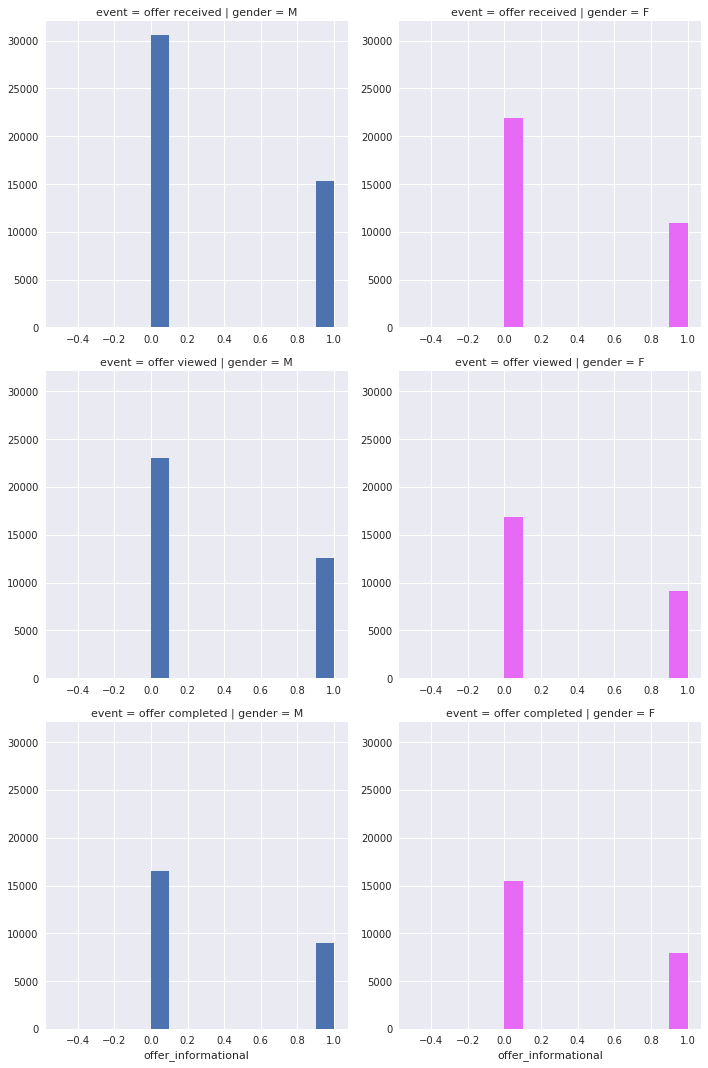

In [117]:
#EDA to determine which offers to be sent to which customers

d = {'color': ['C0', "#e76af7"]}
g = sns.FacetGrid(plot_gender, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_bogo')
g.map(plt.hist, 'offer_discount')
g.map(plt.hist, 'offer_informational')

In [118]:
#model comparison
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model, d_model, e_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1, d_train_f1, e_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1, d_test_f1, e_test_f1]}
          
comparison = pd.DataFrame(models)

In [119]:
comparison

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),53.101934,32.209939
1,RandomForestClassifier,94.496153,68.483922
2,DecisionTreeClassifier,95.704669,85.561641
3,AdaBoostClassifier,92.670497,92.725379
4,GaussianNB,63.658255,63.248883
